In [1]:
import tensorflow as tf
import keras
import numpy as np
import pandas as pd
from os import listdir
from os.path import isfile, join
import os
import matplotlib.pyplot as plt
import scipy.io.wavfile as wav
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
import librosa
import seaborn as sns
import sklearn.metrics
import h5py

Using TensorFlow backend.


In [2]:
dir_path = '/home/duh17/Desktop/free-spoken-digit-dataset/recordings/'
file_names = [f for f in listdir(dir_path) if isfile(join(dir_path, f)) and '.wav' in f]

In [3]:
def save_model(model) :
    model.save('MFCC.h5')

def load_model() :
    model = keras.models.load_model('MFCC.h5')
    return model

def load_from_wav(dir_path, file_names):
    lst = []
    for file_name in file_names :
    #     print(file_name)
        sample, sample_rate = librosa.load(dir_path+file_name, sr=8000)
        mfccs = librosa.feature.mfcc(y=sample, sr=sample_rate, n_mfcc=24)
        lst.append([mfccs, file_name])
    return lst

# save and load data X, y
def input2file(X, Y):
    f = h5py.File('input.h5', 'w')
    f['X'] = X
    f['Y'] = Y
    f.close()

def file2input():
    f = h5py.File('input.h5', 'r')
    X = f['X'][:]
    Y = f['Y'][:]
    f.close()
    return X, Y

def MFCC(inmfcc, maxlength) :
    """
    :inmfcc : input mfcc and file name
    :rtype: truncated mfcc
    """
    outmfcc = inmfcc[0][:,:3]
    return outmfcc

In [ ]:
'''
We have a pretrained model and input.
This Block will re-read the wav files. 
You can use :
X, Y = file2input()
to get the input directly.
''' 
# load wave from .wav file
lst = load_from_wav(dir_path, file_names)
temp = []
# We have 2000 wave files in total
for i in range(2000) :
    temp.append(lst[i][0].shape[1])
min_len_of_input = min(temp)
# lst[4][0][:,:3]

res = []
N_samples = 2000

for i in lst :
#     print(i)
    res.append([MFCC(i, min_len_of_input), i[1]])
# res

#use numpy.array to store X, Y for further process
X = []
Y = []
for i in res :
    X.append(i[0])
    Y.append(int(i[1][0]))
X = np.asarray(X)
tempY = np.asarray(Y)
# Create One-Hot encodings for Y
lsttmp = []
for i in tempY :
    tmp = []
    for numbers in range(10) :
        if numbers == i :
            num = 1
        else :
            num = 0
        tmp.append(num)
    lsttmp.append(tmp)
Y = np.asarray(lsttmp)
# resize X to meet the requirement of Layer Conv2D
X.resize(2000,24,3,1)
print("X: " + X.shape)
print("Y:" + Y.shape)

In [4]:
X, Y = file2input()

In [13]:
# Train and test set splition
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.33, random_state=42)
# X_train = X_train.reshape(1340, 8000, 1)

In [16]:
"""
We have trained a model and you can use load_model() and ignore morel.compile and model.fit to reload it if you just want to check the result.
model = load_model()
"""

# Keras layers settings
model = Sequential()
# model.add(Conv1D(filters=1, kernel_size=10, activation='relu', input_shape=(8000,)))
model.add(Conv2D(32,(2,2),     
                  input_shape=X_train.shape[1:],      
                  activation= 'relu',
                  padding='same')) 
# model.add(Dense(8000, activation='relu'))
#model.add(Conv2D(32, (2,2), padding='valid'))
model.add(MaxPooling2D(2,2))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(10, activation='softmax'))

In [17]:
# Keras training loss and optimization settings
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.Adadelta(),
              metrics=['accuracy'])

In [ ]:
# Model fit
history = model.fit(X_train,y_train, epochs=100, validation_split=0.2)

Train on 1072 samples, validate on 268 samples
Epoch 1/100
1072/1072 [==============================] - 0s 452us/step - loss: 4.0522 - acc: 0.1978 - val_loss: 1.9115 - val_acc: 0.3246
Epoch 2/100
1072/1072 [==============================] - 0s 117us/step - loss: 1.9455 - acc: 0.2892 - val_loss: 1.5942 - val_acc: 0.4515
Epoch 3/100
1072/1072 [==============================] - 0s 115us/step - loss: 1.6745 - acc: 0.3797 - val_loss: 1.5270 - val_acc: 0.4104
Epoch 4/100
1072/1072 [==============================] - 0s 118us/step - loss: 1.5754 - acc: 0.3881 - val_loss: 1.2453 - val_acc: 0.5261
Epoch 5/100
1072/1072 [==============================] - 0s 119us/step - loss: 1.3887 - acc: 0.4646 - val_loss: 1.1388 - val_acc: 0.5299
Epoch 6/100
1072/1072 [==============================] - 0s 112us/step - loss: 1.2392 - acc: 0.5121 - val_loss: 0.9938 - val_acc: 0.6269
Epoch 7/100
1072/1072 [==============================] - 0s 115us/step - loss: 1.1678 - acc: 0.5410 - val_loss: 1.0348 - val_acc: 0

1072/1072 [==============================] - 0s 109us/step - loss: 0.1185 - acc: 0.9608 - val_loss: 0.1686 - val_acc: 0.9552
Epoch 61/100
1072/1072 [==============================] - 0s 132us/step - loss: 0.1248 - acc: 0.9580 - val_loss: 0.1733 - val_acc: 0.9552
Epoch 62/100
  32/1072 [..............................] - ETA: 0s - loss: 0.0817 - acc: 0.9688

In [6]:
model = load_model()

W0306 14:59:20.454050 139983367681536 deprecation.py:506] From /usr/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [7]:
# Model evaluation
y_pred = model.predict(X_test)
model.evaluate(X_test, y_test)

660/660 [==============================] - 0s 109us/step


[0.08323432238716068, 0.9712121212121212]

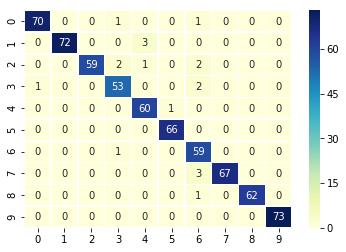

In [8]:
# Confusion Matrix
matrix = sklearn.metrics.confusion_matrix(y_test.argmax(axis=1), y_pred.argmax(axis=1))
sns.heatmap(matrix, annot=True, fmt="d", linewidths=.5, cmap="YlGnBu")
plt.savefig("confusion_heatgraph.png", dpi=600)

In [9]:
# Model Graph
from keras.utils import plot_model
plot_model(model, to_file='model.svg', show_shapes=True)

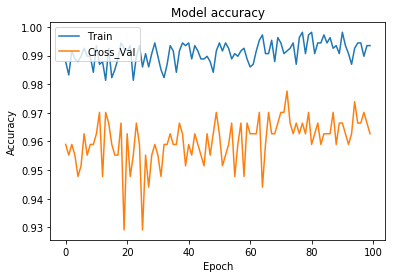

In [12]:
# accu plot
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_Val'], loc='upper left')
plt.savefig("accuracy.png", dpi=600)
plt.show()

In [ ]:
# loss plot
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Cross_Val'], loc='upper left')
plt.savefig("loss.png", dpi=600)
plt.show()